## Notenbonusprojekt
### Segmentierung von Stammkunden
** **

Für dieses Projekt liegen 200 Stammkundendaten vor. Es wird im Folgenden ein
Cluster-Algorithmus entwickelt, mit welchem dann die Segmentierung der Kunden
stattfindet. Daraus werden dann im Anschluss Handlungsempfehlungen abgeleitet.

** **

1. Um den Datensatz verwenden zu können, wird dieser zu Beginn eingelesen. Anschließend
werden die Attribute Alter, Jährliches Einkommen und Monatsausgaben standardisiert,
um im Späteren besser mit den Daten arbeiten zu können. Die Standardisierung erfolgt
mithilfe der _z-Transformation_ . Dies ist sinnvoll, da Daten in einem Datensatz
oftmals unterschiedlich skaliert sind. Die Transformation liefert eine einheitliche
Skalierung.

In [35]:
#Zu Beginn werden die Kundendaten mit dem Package Pandas eingelesen; importiere
#noch weiter wichtige Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, metrics



kunden = pd.read_csv('Kundendaten.csv', index_col= 0, delimiter=";", decimal=",")

kunden.rename(columns={'Alter':'Alter', 'Jährliches Einkommen (k€)':'Einkommen', 'Monatsausgaben (Indexwert, 1-100)':'Monatsausgaben'}, inplace = True)

for col in kunden.columns: #iteriert über alle Spalten im Datensatz
    if col == 'Geschlecht':
        continue
    kunden['z_' + col] = (kunden[col]-kunden[col].mean())/kunden[col].std()
X = kunden[['z_Alter', 'z_Einkommen', 'z_Monatsausgaben']].values #Variablen auswählen auf deren Basis klassifiziert werden soll

Die folgende Tabelle zeigt nun den Datensatz mit allen Werten. Es wurden die standardisierten
Werte hinzugefügt, welche mit einem __z__ beginnen.

In [36]:
kunden.head()
#print(X)

,Geschlecht,Alter,Einkommen,Monatsausgaben,z_Alter,z_Einkommen,z_Monatsausgaben
KundenID,,,,,,,
1,Male,19,15,39,-1.421003,-1.734646,-0.433713
2,Male,21,15,81,-1.277829,-1.734646,1.192711
3,Female,20,16,6,-1.349416,-1.696572,-1.711618
4,Female,23,16,77,-1.134655,-1.696572,1.037814
5,Female,31,17,40,-0.561958,-1.658498,-0.394989


2. Da wir nun die standardisierten Werte errechnet haben, können wir die erste Methode
zur Kundensegmentierung anwenden. Diese nennt sich die _Ellbogenmethode_ .

In [37]:
#Ellbogenmethode
ss = []
krange = list(range(1, 11)) #Hier einstellen, für welches Intervall die sum of squared errors berechnet werden soll
for n in krange:
    model = cluster.KMeans(n_clusters=n, random_state=10)
    model.fit_predict(X)
    cluster_assignments = model.labels_
    centers = model.cluster_centers_
    ss.append(np.sum((X - centers[cluster_assignments]) ** 2))

Die Grafik zeigt nun das Ergebnis der _Ellbogenmethode_ . Wir sehen, dass bei k=6 die
Fehlerquadrate am wenigsten abfallen.

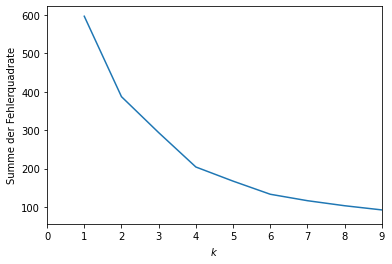

In [38]:
plt.plot(krange, ss)
plt.xlabel("$k$")
plt.ylabel("Summe der Fehlerquadrate")
plt.xlim(0,9)
plt.show()  #k=6


3. Es folgt nun die Methode nach dem Silhouettenkoeffizient. Hier suchen wir das k nach dem
höchsten mittleren Silhouettenkoeffizienten. Dieser wird mithilfe einer _for-Schleife_
berechnet. Er gibt an, wie gut Cluster voneinander abgegrenz sind.
Anschließend wird das Ergebnis grafisch dargestellt.

In [39]:
#Silhouettenkoeffizient
krange = list(range(2, 11))
avg_silhouettes = []
for n in krange:
    model = cluster.KMeans(n_clusters=n, random_state=10)
    model.fit_predict(X)
    cluster_assignments = model.labels_
    silhouette_avg = metrics.silhouette_score(X, cluster_assignments)
    avg_silhouettes.append(silhouette_avg)

Die Grafik zeigt uns nun das Ergebnis der Berechnung. Wie schon bei der Ellbogenmethode,
ist auch hier wieder k=6. Somit ist k=6 basierend auf dem Silhouettenkoeffizienten
die beste Wahl.

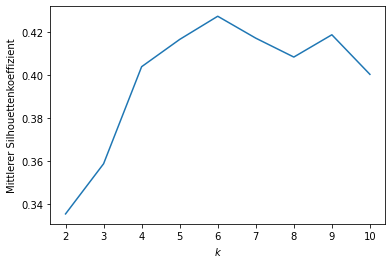

In [40]:
plt.plot(krange, avg_silhouettes)
plt.xlabel("$k$")
plt.ylabel("Mittlerer Silhouettenkoeffizient")
plt.show() #k = 6 ist basierend auf dem Silhouettenkoeffizienten die beste Wahl


** **

4. Die Methoden haben uns gezeigt, wie gut die Anzahl an Clustern
zu unseren Daten passt. Nun wird die k-Means-Methode angewandt. Hierbei
werden wir __drei__ verschiedene Clusterzentren verwenden. Wir nehmen dazu
k=2, k=4 und k=6. Hierbei wird jede Dateninstanz dem nächstgelegenen
Clusterzentrum zugeordnet. Dies wird farblich in den Grafiken dargestellt.

Die Grafiken sind 3-Dimensional, wobei die Attribute das Alter, Einkommen
und die Montasausgaben sind.

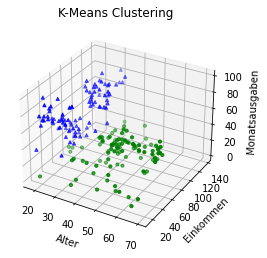

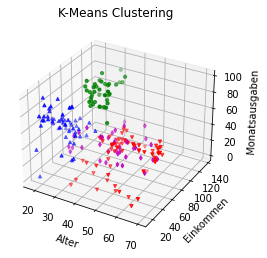

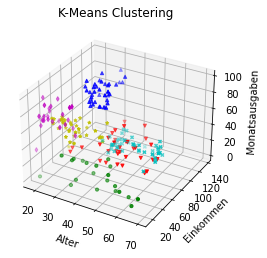

In [41]:
#k-Means Clustering

for n in [2,4,6]:
    model = cluster.KMeans(n_clusters=n, random_state=10)
    cluster_assignments = model.fit_predict(X)
    kunden['cluster']=model.labels_
    colors = ['b','g','m','red','y','c']
    markers = ['^','o','d','v','*','x']


    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for c in kunden['cluster'].unique():
        d = kunden[kunden['cluster'] == c]
        xs = d['Alter']
        ys = d['Einkommen']
        zs = d['Monatsausgaben']
        ax.scatter(xs, ys, zs,marker=markers[c], color=colors[c], s=10)
    plt.title('K-Means Clustering')
    ax.set_xlabel('Alter')
    ax.set_ylabel('Einkommen')
    ax.set_zlabel('Monatsausgaben')

    plt.show()

c:\users\mdrek\onedrive\dokumente\dba python\venv\lib\site-packages\sklearn\cluster\_mean_shift.py:247: UserWarning: Binning data failed with provided bin_size=0.100000, using data points as seeds.
  warnings.warn(


Maximum des Silhouettenkoeffizienten für eine Bandweite von: 1.1


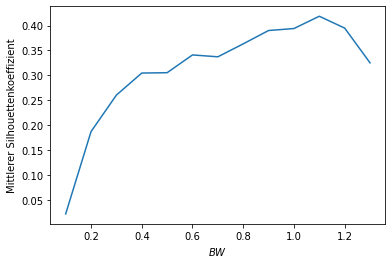

In [42]:
#e)
#Mean-Shift
krange = list(range(1,14))
avg_silhouettes = []
bws=[]
for n in krange:
    bw=n/10
    model = cluster.MeanShift(bandwidth=bw, bin_seeding=True)
    cluster_assignments = model.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_assignments)
    avg_silhouettes.append(silhouette_avg)
    bws.append(bw)

print('Maximum des Silhouettenkoeffizienten für eine Bandweite von:', krange[max(range(len(avg_silhouettes)), key=avg_silhouettes.__getitem__)]/10)
plt.plot(bws, avg_silhouettes)
plt.xlabel("$BW$")
plt.ylabel("Mittlerer Silhouettenkoeffizient")
plt.show()

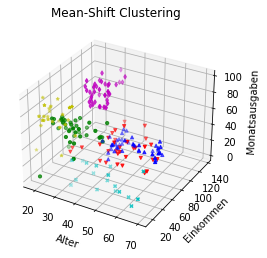

In [43]:
model2=cluster.MeanShift(bandwidth=1.1, bin_seeding=True)
cluster_assignments2 = model2.fit_predict(X)
kunden['cluster2']=model2.labels_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for c in kunden['cluster2'].unique():
    d = kunden[kunden['cluster2'] == c]
    xs = d['Alter']
    ys = d['Einkommen']
    zs = d['Monatsausgaben']
    ax.scatter(xs, ys, zs,marker=markers[c], color=colors[c], s=10)

plt.title('Mean-Shift Clustering')
ax.set_xlabel('Alter')
ax.set_ylabel('Einkommen')
ax.set_zlabel('Monatsausgaben')

plt.show()
